### Sentiment Analysis on .json Dataset <br> Pre-trained Models <br> VADER, TextBlob, and Flair

#### Importing Modules and Loading in Dataset

In [187]:
import pandas as pd  
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import math
#df1 = pd.read_json(path_or_buf='train.jsonl', lines=True)
#df = pd.read_csv('weather-agg-DFE.csv')
df = pd.read_csv('Climate_twitter.csv')

#### Formatting the Dataset for Sentiment Analysis

In [188]:
df = df.drop(columns=['id','date','source','author','twitter_name','location','verified','retweets','likes','followers','friends'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text          396 non-null    object 
 1   polarity      396 non-null    float64
 2   subjectivity  396 non-null    float64
dtypes: float64(2), object(1)
memory usage: 9.4+ KB


In [189]:
conditions = [
    (df['polarity'] <= -0.05),
    (df['polarity'] > -0.05) & (df['polarity'] < 0.05),
    (df['polarity'] >= 0.05)]

values = [-1,0,1]

df['Label'] = np.select(conditions, values)

df.head()

,text,polarity,subjectivity,Label
0,The death of summer Arctic ice our Earth coole...,-0.054365,0.426984,-1
1,Elsevier and the EditorsinChief are pleased to...,0.387500,0.633333,1
2,From better climate change education to improv...,0.261905,0.345238,1
3,climate change Links to FIXING CLIMATE CHANGE ...,0.000000,0.000000,0
4,climate change The 11TH HOUR FOR THE EARTH cli...,0.000000,0.000000,0


In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text          396 non-null    object 
 1   polarity      396 non-null    float64
 2   subjectivity  396 non-null    float64
 3   Label         396 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 12.5+ KB


In [191]:
# convert text column to string for easier processing
df['text'] = df['text'].astype("string")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text          396 non-null    string 
 1   polarity      396 non-null    float64
 2   subjectivity  396 non-null    float64
 3   Label         396 non-null    int64  
dtypes: float64(2), int64(1), string(1)
memory usage: 12.5 KB


In [192]:
df.head()

,text,polarity,subjectivity,Label
0,The death of summer Arctic ice our Earth coole...,-0.054365,0.426984,-1
1,Elsevier and the EditorsinChief are pleased to...,0.387500,0.633333,1
2,From better climate change education to improv...,0.261905,0.345238,1
3,climate change Links to FIXING CLIMATE CHANGE ...,0.000000,0.000000,0
4,climate change The 11TH HOUR FOR THE EARTH cli...,0.000000,0.000000,0


#### Cleaning Text for "Cleaned" Column to Compare Analysis Results

In [193]:
# First, we will expand contractions for better analysis using a dictionary of English Contractions from analyticsvidhya.com.
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}
# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df['cleaned']=df['text'].apply(lambda x:expand_contractions(x))

In [194]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

In [195]:
df.cleaned = df.text.apply(clean)

In [196]:
# Next, we will lowercase all the messages. 
df['cleaned']=df['text'].apply(lambda x: x.lower())

In [197]:
# Next, we will remove digits and words containing digits.
df['cleaned'] = df['cleaned'].apply(lambda x: re.sub('\w*\d\w*','',x))

In [198]:
# Finally, we will remove punctuations in the messages. 
df['cleaned'] = df['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [199]:
# Removing extra spaces
df['cleaned'] = df['cleaned'].apply(lambda x: re.sub(' +', ' ',x))

In [200]:
df.sample(10)

,text,polarity,subjectivity,Label,cleaned
228,Melting Glacier Reveals More Evidence Of Very ...,0.363333,0.346667,1,melting glacier reveals more evidence of very ...
169,What is all this hype about Global Warming Is ...,0.250000,0.250000,1,what is all this hype about global warming is ...
275,New Podcast Is Greta Thunberg right about Clim...,0.084686,0.310065,1,new podcast is greta thunberg right about clim...
326,Did you knowtechexplorist climate researchers ...,-0.016667,0.133333,0,did you knowtechexplorist climate researchers ...
144,Climate change is poised to thaw and undermine...,-0.166667,0.208333,-1,climate change is poised to thaw and undermine...
371,BBCWorld 3 climate used as supporting evidence...,0.286667,0.466667,1,bbcworld climate used as supporting evidence t...
282,I think that rather than harass world leaders ...,0.050000,0.425000,1,i think that rather than harass world leaders ...
364,Climate Change Conservation Science Global War...,0.000000,0.000000,0,climate change conservation science global war...
13,Warming oceans contribute to storms that could...,0.245455,0.466667,1,warming oceans contribute to storms that could...
333,Councils are ahead of the game on global warmi...,-0.087879,0.284848,-1,councils are ahead of the game on global warmi...


#### VADER Sentiment Analysis

In [201]:
import nltk

# Download the lexicon
nltk.download("vader_lexicon")

# Import the lexicon 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Create an instance of SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tessanderson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [202]:
# adding the predictions as a column in dataset
def format_output(output_dict):
    sentiment=False
    if(output_dict['compound']>=0.05):
        sentiment=1
    elif(output_dict['compound']<=-0.05):
        sentiment=-1
    else:
        sentiment=0
    return sentiment
def predict_sentiment(text):
    output_dict = sent_analyzer.polarity_scores(text)
    return format_output(output_dict)

# running the predictions
df['Vader_Prediction']=df['text'].apply(predict_sentiment)
df.sample(5)
df['C_Vader_Prediction']=df['cleaned'].apply(predict_sentiment)
df.sample(5)

,text,polarity,subjectivity,Label,cleaned,Vader_Prediction,C_Vader_Prediction
152,deserts TURNING DESERTS INTO FORESTS climate c...,0.000000,0.000000,0,deserts turning deserts into forests climate c...,1,1
320,Top 10 Major Causes of Global Warming that cha...,0.187500,0.333333,1,top major causes of global warming that change...,1,1
82,More than 45 of the US is experiencing drought...,0.126786,0.522619,1,more than of the us is experiencing drought co...,-1,-1
263,KOLKATA Climate change and global warming may ...,0.000000,0.000000,0,kolkata climate change and global warming may ...,1,1
342,Blended fuels with high black carbon emissions...,-0.020556,0.412222,0,blended fuels with high black carbon emissions...,-1,-1


In [203]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(df['Label'],df['Vader_Prediction'])

print("Accuracy: {}\n".format(accuracy))

print(classification_report(df['Label'],df['Vader_Prediction']))

Accuracy: 0.3939393939393939

              precision    recall  f1-score   support

          -1       0.30      0.69      0.42        61
           0       0.63      0.07      0.12       179
           1       0.43      0.65      0.52       156

    accuracy                           0.39       396
   macro avg       0.45      0.47      0.35       396
weighted avg       0.50      0.39      0.32       396



In [204]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(df['Label'],df['C_Vader_Prediction'])

print("Accuracy: {}\n".format(accuracy))

print(classification_report(df['Label'],df['C_Vader_Prediction']))

Accuracy: 0.3939393939393939

              precision    recall  f1-score   support

          -1       0.30      0.69      0.42        61
           0       0.63      0.07      0.12       179
           1       0.43      0.65      0.52       156

    accuracy                           0.39       396
   macro avg       0.45      0.47      0.35       396
weighted avg       0.50      0.39      0.32       396



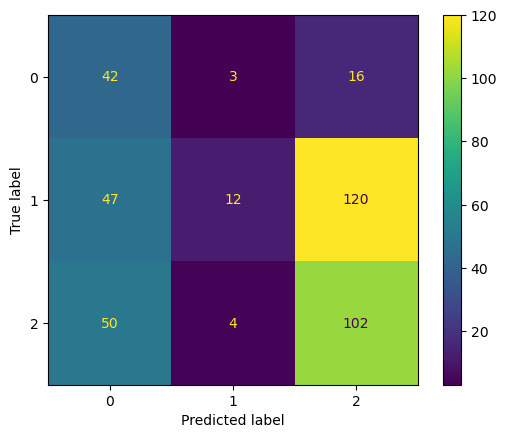

In [205]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(df['Label'], df['Vader_Prediction'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

#### TextBlob Sentiment Analysis

In [206]:
from textblob import TextBlob

In [207]:
def sentiment_analysis(text):
 def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity
  
 #Create a function to get the polarity
 def getPolarity(text):
   return TextBlob(text).sentiment.polarity
  
 #Create two new columns ‘Subjectivity’ & ‘Polarity’
 text['TextBlob_Subjectivity'] = text['text'].apply(getSubjectivity)
 text ['TextBlob_Polarity'] = text['text'].apply(getPolarity)
 def getAnalysis(score):
  if score < 0:
    return -1
  elif score == 0:
    return 0
  else:
    return 1
 text ['TextBlob_Analysis'] = text  ['TextBlob_Polarity'].apply(getAnalysis )
 return text

In [208]:
def Csentiment_analysis(text):
 def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity
  
 #Create a function to get the polarity
 def getPolarity(text):
   return TextBlob(text).sentiment.polarity
  
 #Create two new columns ‘Subjectivity’ & ‘Polarity’
 text['CTextBlob_Subjectivity'] = text['cleaned'].apply(getSubjectivity)
 text ['CTextBlob_Polarity'] = text['cleaned'].apply(getPolarity)
 def getAnalysis(score):
  if score < 0:
    return -1
  elif score == 0:
    return 0
  else:
    return 1
 text ['CTextBlob_Analysis'] = text  ['CTextBlob_Polarity'].apply(getAnalysis )
 return text

In [209]:
df = sentiment_analysis(df)
df = Csentiment_analysis(df)

In [210]:
df.head()

,text,polarity,subjectivity,Label,cleaned,Vader_Prediction,C_Vader_Prediction,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis,CTextBlob_Subjectivity,CTextBlob_Polarity,CTextBlob_Analysis
0,The death of summer Arctic ice our Earth coole...,-0.054365,0.426984,-1,the death of summer arctic ice our earth coole...,-1,-1,0.426984,-0.054365,-1,0.426984,-0.054365,-1
1,Elsevier and the EditorsinChief are pleased to...,0.387500,0.633333,1,elsevier and the editorsinchief are pleased to...,1,1,0.633333,0.387500,1,0.633333,0.387500,1
2,From better climate change education to improv...,0.261905,0.345238,1,from better climate change education to improv...,1,1,0.345238,0.261905,1,0.345238,0.261905,1
3,climate change Links to FIXING CLIMATE CHANGE ...,0.000000,0.000000,0,climate change links to fixing climate change ...,1,1,0.000000,0.000000,0,0.000000,0.000000,0
4,climate change The 11TH HOUR FOR THE EARTH cli...,0.000000,0.000000,0,climate change the hour for the earth climatec...,1,1,0.000000,0.000000,0,0.000000,0.000000,0


In [211]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(df['Label'],df['CTextBlob_Analysis'])

print("Accuracy: {}\n".format(accuracy))

print(classification_report(df['Label'],df['CTextBlob_Analysis']))

Accuracy: 0.8661616161616161

              precision    recall  f1-score   support

          -1       0.76      1.00      0.87        61
           0       1.00      0.70      0.83       179
           1       0.82      1.00      0.90       156

    accuracy                           0.87       396
   macro avg       0.86      0.90      0.86       396
weighted avg       0.89      0.87      0.86       396



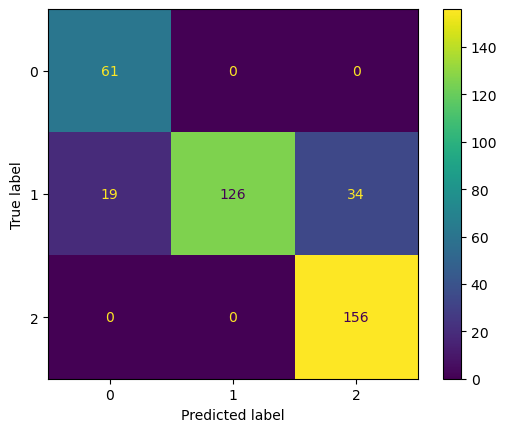

In [212]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(df['Label'], df['TextBlob_Analysis'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

#### Flair Sentiment Analysis

In [213]:
import flair
from flair.models import TextClassifier
from flair.data import Sentence
from segtok.segmenter import split_single
import re

sia = TextClassifier.load('en-sentiment')

In [214]:
def sentiment_Flair(x):
    sentence = Sentence(x)
    sia.predict(sentence)
    score = sentence.labels[0]
    if "POSITIVE" in str(score):
        return 1
    elif "NEGATIVE" in str(score):
        return -1
    else:
        return 0

In [215]:
df['Flair_Sentiment'] = df['text'].apply(lambda x: sentiment_Flair(x))
df['C_Flair_Sentiment'] = df['cleaned'].apply(lambda x: sentiment_Flair(x))

In [216]:
df.head()

,text,polarity,subjectivity,Label,cleaned,Vader_Prediction,C_Vader_Prediction,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis,CTextBlob_Subjectivity,CTextBlob_Polarity,CTextBlob_Analysis,Flair_Sentiment,C_Flair_Sentiment
0,The death of summer Arctic ice our Earth coole...,-0.054365,0.426984,-1,the death of summer arctic ice our earth coole...,-1,-1,0.426984,-0.054365,-1,0.426984,-0.054365,-1,-1,-1
1,Elsevier and the EditorsinChief are pleased to...,0.387500,0.633333,1,elsevier and the editorsinchief are pleased to...,1,1,0.633333,0.387500,1,0.633333,0.387500,1,1,1
2,From better climate change education to improv...,0.261905,0.345238,1,from better climate change education to improv...,1,1,0.345238,0.261905,1,0.345238,0.261905,1,1,1
3,climate change Links to FIXING CLIMATE CHANGE ...,0.000000,0.000000,0,climate change links to fixing climate change ...,1,1,0.000000,0.000000,0,0.000000,0.000000,0,1,1
4,climate change The 11TH HOUR FOR THE EARTH cli...,0.000000,0.000000,0,climate change the hour for the earth climatec...,1,1,0.000000,0.000000,0,0.000000,0.000000,0,1,1


In [221]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(df['Label'],df['C_Flair_Sentiment'])

print("Accuracy: {}\n".format(accuracy))

print(classification_report(df['Label'],df['C_Flair_Sentiment']))

Accuracy: 0.3181818181818182

              precision    recall  f1-score   support

          -1       0.19      0.57      0.29        61
           0       0.00      0.00      0.00       179
           1       0.43      0.58      0.49       156

    accuracy                           0.32       396
   macro avg       0.21      0.39      0.26       396
weighted avg       0.20      0.32      0.24       396



/Users/tessanderson/anaconda3/envs/thesiswork/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/tessanderson/anaconda3/envs/thesiswork/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/tessanderson/anaconda3/envs/thesiswork/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



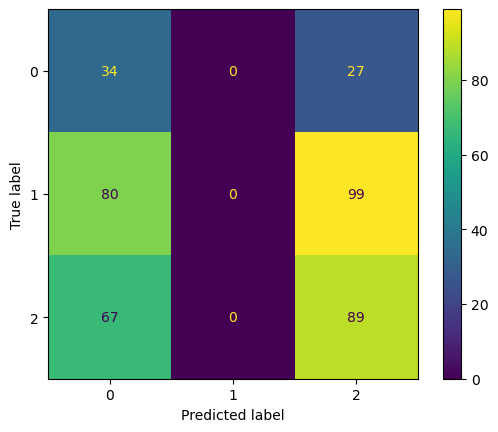

In [218]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(df['Label'], df['Flair_Sentiment'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()